In [ ]:
############################
# 1) SETUP AND IMPORTS
############################
!pip install focal-loss --quiet  # (Optional)

from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC
import tensorflow as tf
from sklearn.metrics import f1_score


############################
# 2) UNZIP CHEXPERT DATASET
############################
# Make sure you have "archive.zip" (the CheXpert dataset) in your Drive
!unzip -q "/content/drive/MyDrive/archive.zip" -d /content/chexpert

# Check folder
print("Files in /content/chexpert:")
print(os.listdir('/content/chexpert'))

Mounted at /content/drive
Files in /content/chexpert:
['train', 'valid', 'valid.csv', 'train.csv']


In [ ]:
############################
# 3) LOAD & INSPECT DATA
############################
train_csv_path = "/content/chexpert/train.csv"  # Adjust if needed
df = pd.read_csv(train_csv_path)
print("Total rows in train.csv:", len(df))

# All 14 CheXpert labels (for reference)
all_labels = [
    "No Finding","Enlarged Cardiomediastinum","Cardiomegaly","Lung Opacity","Lung Lesion",
    "Edema","Consolidation","Pneumonia","Atelectasis","Pneumothorax",
    "Pleural Effusion","Pleural Other","Fracture","Support Devices"
]

# OPTIONAL: quick distribution check
print("Label distribution (raw counts of 1, 0, -1, NaN) for each label:")
label_counts = {}
for label in all_labels:
    col = df[label]
    counts = {
        "1.0": (col == 1.0).sum(),
        "0.0": (col == 0.0).sum(),
        "-1.0": (col == -1.0).sum(),
        "NaN": col.isna().sum()
    }
    label_counts[label] = counts
label_counts_df = pd.DataFrame(label_counts).T
label_counts_df.columns = ["Count_1.0", "Count_0.0", "Count_-1.0", "Count_NaN"]
display(label_counts_df)

Total rows in train.csv: 223414
Label distribution (raw counts of 1, 0, -1, NaN) for each label:


,Count_1.0,Count_0.0,Count_-1.0,Count_NaN
No Finding,22381,0,0,201033
Enlarged Cardiomediastinum,10798,21638,12403,178575
Cardiomegaly,27000,11116,8087,177211
Lung Opacity,105581,6599,5598,105636
Lung Lesion,9186,1270,1488,211470
Edema,52246,20726,12984,137458
Consolidation,14783,28097,27742,152792
Pneumonia,6039,2799,18770,195806
Atelectasis,33376,1328,33739,154971
Pneumothorax,19448,56341,3145,144480


In [ ]:


############################
# 4) FILTER DATA & DEFINE LABELS
############################
# Load metadata
csv_path = "/content/chexpert/train.csv"
df = pd.read_csv(csv_path)

# Add full image path
df["filepath"] = df["Path"].apply(lambda x: str(Path("/content/chexpert") / Path(x).relative_to("CheXpert-v1.0-small")))

# Filter to frontal images only
df = df[df["Frontal/Lateral"] == "Frontal"]

# Select diagnoses
target_labels = ["Pleural Effusion", "Edema", "Cardiomegaly"] # Tried a few times, going for this combo due to fair amount of data and balance.

# Replace -1 with 0 (treat uncertainty as negative)
df[target_labels] = df[target_labels].replace(-1.0, 0.0)

# Drop rows where any of the selected labels are NaN
df = df.dropna(subset=target_labels)

# Drop rows where image doesn't exist
df = df[df["filepath"].apply(lambda x: Path(x).is_file())]

# Show filtered shape and label distributions
print("Filtered shape:", df.shape)
display(df[target_labels].apply(pd.Series.value_counts).fillna(0).astype(int))

############################
# 5) SPLIT INTO TRAIN/VAL
############################
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42
).copy()

print(f"Train set shape: {train_df.shape}")
print(f"Validation set shape: {val_df.shape}")



<ipython-input-3-ff41f20cfd9d>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target_labels] = df[target_labels].replace(-1.0, 0.0)


Filtered shape: (13180, 20)


,Pleural Effusion,Edema,Cardiomegaly
1.0,8745,8009,9278
0.0,4435,5171,3902


Train set shape: (10544, 20)
Validation set shape: (2636, 20)


In [ ]:
############################
# 6) IMAGE DATA GENERATORS
############################
# We will use color mode = "rgb" so that our DenseNet (pretrained on ImageNet) can handle 3 channels.
# You can replicate grayscale images into three channels, but typically just letting Keras load them as RGB is fine.
IMG_SIZE = (256, 256)
BATCH_SIZE = 16

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # Use DenseNet's built-in preprocessor
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col=target_labels,
    target_size=IMG_SIZE,
    color_mode='rgb',
    class_mode='raw',  # multi-label => 'raw'
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col=target_labels,
    target_size=IMG_SIZE,
    color_mode='rgb',
    class_mode='raw',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 10544 validated image filenames.
Found 2636 validated image filenames.


In [ ]:
############################
# 7) BUILD PRETRAINED DENSENET
############################
from focal_loss import BinaryFocalLoss

def create_densenet_model(input_shape=(256, 256, 3), num_classes=3, freeze_until=None):
    """
    freeze_until: layer name or index until which layers are frozen (optional).
    """
    base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=input_shape)

    ## OPTIONAL: Freeze some or all layers of base_model. For example:
    if freeze_until is not None:
       trainable = False
       for layer in base_model.layers:
           if layer.name == freeze_until:
            trainable = True
           layer.trainable = trainable
    else:
         # freeze entire base_model
        for layer in base_model.layers:
             layer.trainable = False

    # Add new top layers
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=outputs)

    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss=BinaryFocalLoss(gamma=2),
        metrics=[AUC(multi_label=True, name='auc')]
    )

    return model

model = create_densenet_model(input_shape=(256, 256, 3), num_classes=len(target_labels))
model.summary()


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 64, 64,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 64, 64,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 64, 64,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 64, 64,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 64, 64,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 64, 64,    │     12,288 │ conv2_block2_0_r

 Total params: 7,040,579 (26.86 MB)

 Trainable params: 3,075 (12.01 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
############################
# 7.5) RESUME FROM LATEST CHECKPOINT (if exists)
############################
from tensorflow.keras.models import load_model
import glob

checkpoint_dir = "/content/drive/MyDrive/chexpert_checkpoints"
latest_checkpoint = None

# Find all saved models
checkpoint_files = sorted(
    glob.glob(os.path.join(checkpoint_dir, "*.keras")),
    key=os.path.getmtime  # sort by modification time
)

if checkpoint_files:
    latest_checkpoint = checkpoint_files[-1]
    print(f"🔁 Resuming from latest checkpoint:\n{latest_checkpoint}")
    model = load_model(latest_checkpoint)
else:
    print("🆕 No checkpoint found, starting training from scratch.")




🔁 Resuming from latest checkpoint:
/content/drive/MyDrive/chexpert_checkpoints/epoch_03-val_loss_0.5656.keras


In [ ]:

############################
# 8) TRAIN MODEL (WITH CHECKPOINTING)
############################
from tensorflow.keras.callbacks import ModelCheckpoint
import os

# Create a folder in your Google Drive to store the checkpoints
checkpoint_dir = "/content/drive/MyDrive/chexpert_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# Save model after every epoch
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "epoch_{epoch:02d}-val_loss_{val_loss:.4f}.keras"),
    monitor='val_loss',
    save_best_only=False,       # Save every epoch
    save_weights_only=False,    # Save full model
    verbose=1
)

# Full callbacks list
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
    checkpoint_callback  # Added checkpointing here
]

# Start training
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


In [ ]:
# 📈 Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# 📊 Plot AUC
if 'auc' in history.history:
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Val AUC')
    plt.title("Training vs Validation AUC")
    plt.xlabel("Epoch")
    plt.ylabel("AUC")
    plt.legend()
    plt.grid(True)
    plt.show()


KeyError: 'loss'

165/165 ━━━━━━━━━━━━━━━━━━━━ 601s 4s/step - accuracy: 0.5397 - loss: 0.5890
Validation Loss: 0.5656
Validation Accuracy: 0.5580
165/165 ━━━━━━━━━━━━━━━━━━━━ 610s 4s/step
Pleural Effusion: Best threshold=0.29, F1=0.8865
Edema: Best threshold=0.14, F1=0.8262
Cardiomegaly: Best threshold=0.13, F1=0.8470

Classification Report:
                  precision    recall  f1-score   support

Pleural Effusion       0.84      0.94      0.89      1749
           Edema       0.75      0.93      0.83      1628
    Cardiomegaly       0.75      0.97      0.85      1887

       micro avg       0.78      0.95      0.85      5264
       macro avg       0.78      0.94      0.85      5264
    weighted avg       0.78      0.95      0.85      5264
     samples avg       0.71      0.82      0.74      5264

AUC Scores per Label:
Pleural Effusion: 0.8859
Edema: 0.8030
Cardiomegaly: 0.7421


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


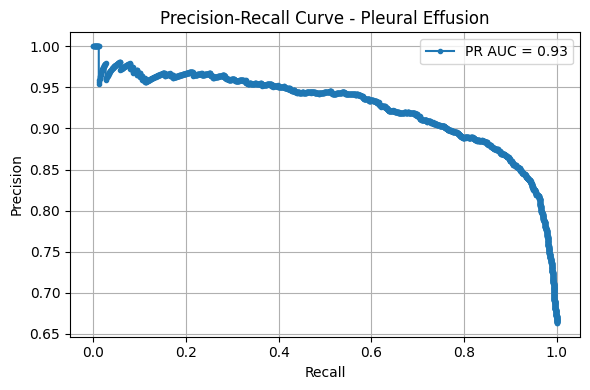

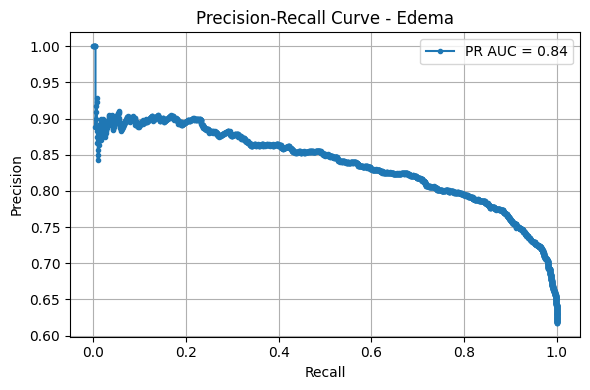

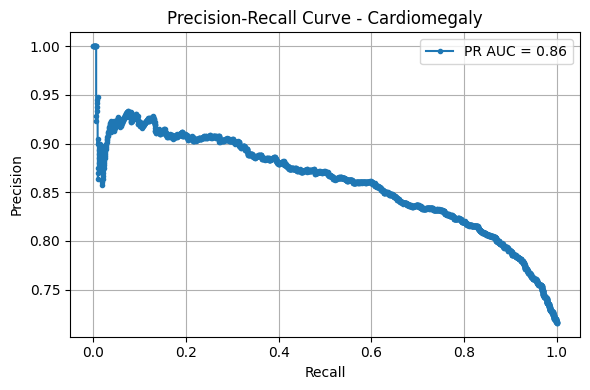

In [ ]:
############################
# 9) EVALUATE MODEL
############################
# Evaluate final model on val set
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

# Predict probabilities
y_pred_prob = model.predict(val_generator)
y_true = val_generator.labels  # ground truth

best_thresholds = []

for i, label in enumerate(target_labels):
    best_thresh = 0.5
    best_f1 = 0
    for t in np.arange(0.0, 1.0, 0.01): # Old:(0.1, 0.9, 0.05)
        temp_pred = (y_pred_prob[:, i] > t).astype(int)
        f1 = f1_score(y_true[:, i], temp_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = t
    best_thresholds.append(best_thresh)
    print(f"{label}: Best threshold={best_thresh:.2f}, F1={best_f1:.4f}")

y_pred = np.zeros_like(y_pred_prob)

for i, threshold in enumerate(best_thresholds):
    y_pred[:, i] = (y_pred_prob[:, i] > threshold).astype(int)

#print(f"F1 at t=0.50 for {label}: {f1_score(y_true[:, i], (y_pred_prob[:, i] > 0.5).astype(int)):.4f}")

# Binarize with threshold=0.5
#y_pred = (y_pred_prob > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=target_labels))

# AUC for each class
print("AUC Scores per Label:")
for i, label in enumerate(target_labels):
    auc_score = roc_auc_score(y_true[:, i], y_pred_prob[:, i])
    print(f"{label}: {auc_score:.4f}")

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

# Plot PR Curve for each class
for i, label in enumerate(target_labels):
    precision, recall, thresholds = precision_recall_curve(y_true[:, i], y_pred_prob[:, i])
    pr_auc = auc(recall, precision)

    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, marker='.', label=f'PR AUC = {pr_auc:.2f}')
    plt.title(f'Precision-Recall Curve - {label}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


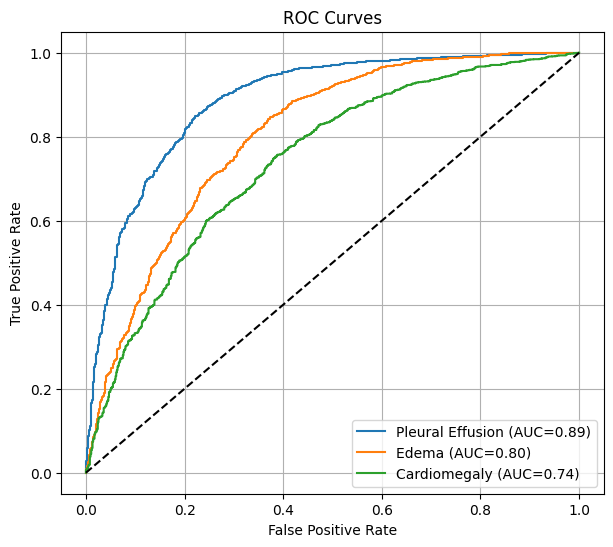

In [ ]:
############################
# 10) PLOT ROC CURVES
############################
plt.figure(figsize=(7,6))
for i, label in enumerate(target_labels):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_prob[:, i])
    auc_score = roc_auc_score(y_true[:, i], y_pred_prob[:, i])
    plt.plot(fpr, tpr, label=f"{label} (AUC={auc_score:.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

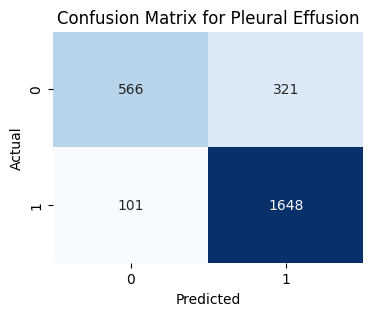

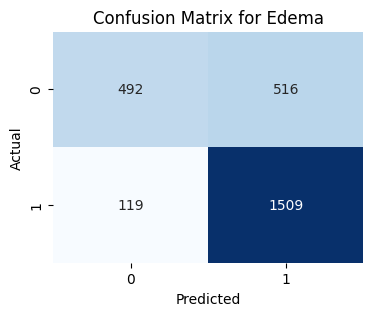

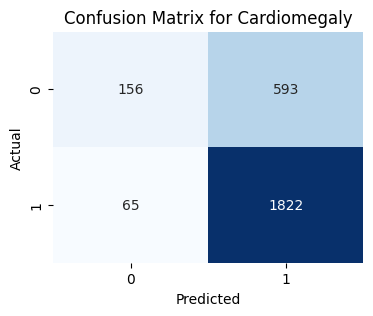

In [ ]:
############################
# 11) CONFUSION MATRIX
############################
for i, label in enumerate(target_labels):
    cm = confusion_matrix(y_true[:, i], y_pred[:, i])
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix for {label}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


Showing Grad-CAM for:
/content/chexpert/train/patient19724/study1/view1_frontal.jpg


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 256, 256, 3))
  warnings.warn(msg)


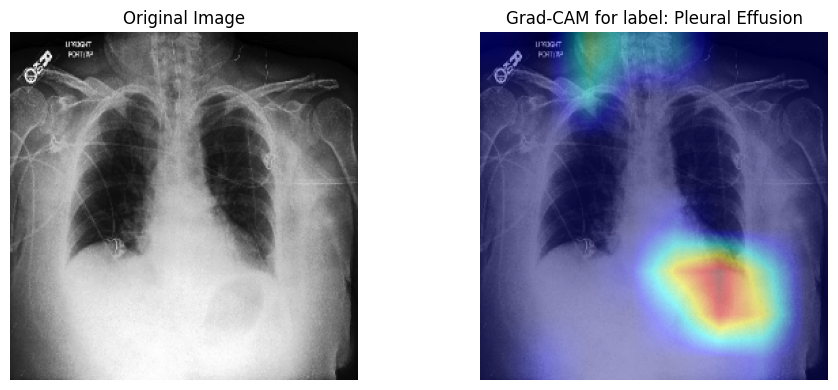

In [ ]:

############################
# 12) GRAD-CAM DEMO
############################
# Example Grad-CAM for a single image from the validation set
import cv2
import numpy as np

def plot_gradcam(model, img_path, layer_name, label_index=0):
    """
    Generates Grad-CAM heatmap for a single label_index on a single image.
    model: your trained model
    img_path: path to an image
    layer_name: name of the last conv layer in DenseNet (e.g., 'conv5_block16_concat')
    label_index: which label (0.. num_classes-1) to visualize
    """
    # 1) Load & preprocess image
    img = tf.keras.utils.load_img(img_path, target_size=IMG_SIZE)
    x = tf.keras.utils.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)  # DenseNet's preprocess

    # 2) Forward pass
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(x)
        loss = predictions[:, label_index]  # focusing on specific label

    # 3) Compute gradients
    grads = tape.gradient(loss, conv_outputs)
    # Global average pooling across spatial dimensions
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # 4) Weight the channels by corresponding gradients
    conv_outputs = conv_outputs[0]          # shape: (H, W, Channels)
    pooled_grads = pooled_grads            # shape: (Channels,)
    conv_outputs = conv_outputs * pooled_grads
    heatmap = tf.reduce_mean(conv_outputs, axis=-1)  # average out channels -> shape: (H, W)

    # 5) Normalize the heatmap for visualization
    heatmap = np.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-8)
    heatmap = heatmap.numpy()

    # 6) Superimpose on original image
    # Load original image in openCV
    img_orig = cv2.imread(img_path)
    img_orig = cv2.resize(img_orig, IMG_SIZE)

    heatmap = cv2.resize(heatmap, (IMG_SIZE[1], IMG_SIZE[0]))
    heatmap = np.uint8(255 * heatmap)

    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(heatmap_color, 0.4, img_orig, 0.6, 0)

    # 7) Display side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    axes[1].set_title(f"Grad-CAM for label: {target_labels[label_index]}")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

# Pick a random validation sample
sample_idx = np.random.randint(len(val_df))
sample_path = val_df.iloc[sample_idx]["filepath"]
print(f"Showing Grad-CAM for:\n{sample_path}")

# The last DenseNet layer you can target is typically "conv5_block16_concat" or check model.summary()
plot_gradcam(model, sample_path, layer_name='conv5_block16_concat', label_index=0)
